In [2]:
import pandas as pd
import csv
import operator
import json
from os import listdir
from pathlib import Path
import configparser

from IPython.display import FileLink, FileLinks, display
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

from _helpers import *

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,9)})

In [5]:
root = Path('../../')
Config = configparser.ConfigParser()
Config.read(str(root / 'config.cnf'))

# Load files from disk
path = str(root / Config.get('output_files', 'summary_tweets'))
tweets = pd.read_csv(path)

path = str(root / Config.get('output_files', 'tweets'))
input_dir = root / path

output_dir = Path("temp/")

In [5]:
data_dir = Path("../../data/")

queries = load_queries(data_dir / "queries.csv")
refetched_tweets = data_dir / "refetched_tweets"
refetched_tweets_files = refetched_tweets.glob("*.csv")

dfs = []
for file in refetched_tweets_files:
    q = file.name.split(".")[0]
    df = pd.read_csv(file, 
                     dtype={
                         'tweet_id': str,
                         'user_id': str,
                         'retweeted_status': str,
                         'quoted_status': str,
                         'in_reply_to': str
                     })
    venue = queries.loc[queries['query'] == q, "venue_short"].iloc[0]
    df['venue'] = venue
    dfs.append(df)
tweets = pd.concat(dfs)

In [16]:
x = tweets.groupby("venue").count()
x['total'] = queries.groupby('venue_short')['found_tweets'].sum()
x['is_truncated'] = tweets.groupby("venue")['is_truncated'].sum()
x['refetched'] = tweets.groupby("venue")['refetched'].sum()

x = x[['total', 'posted_on', 'retweeted_status', 'quoted_status', 'in_reply_to', 'urls', 'is_truncated', 'refetched', 'error']]
x.to_csv("../../data/output/tweet_summary.csv")

In [15]:
display(x)

,total,posted_on,retweeted_status,quoted_status,in_reply_to,urls,is_truncated,refetched,error
venue,,,,,,,,,
bostonglobe,32250,18803,14220,1054,160,12968,32.0,374.0,32
chicago,2003,834,564,1,5,566,2.0,27.0,2
foxnews,431310,230560,127464,41574,2621,171988,546.0,2887.0,546
iflscience,333099,184413,54389,1917,3005,169453,156.0,3128.0,156
latimes,203134,126505,72231,1619,1207,100775,461.0,2860.0,461
nytimes,1783887,1126085,696753,14902,6954,842344,1022.0,15463.0,1022
sfchronicle,15058,9879,7004,72,44,6841,13.0,140.0,13
slate,9165,1878,983,56,21,1652,3.0,49.0,3
theglobeandmail,36662,26204,18076,98,619,17586,37.0,482.0,37


Download the table [here]("../../data/output/tweet_summary.csv")

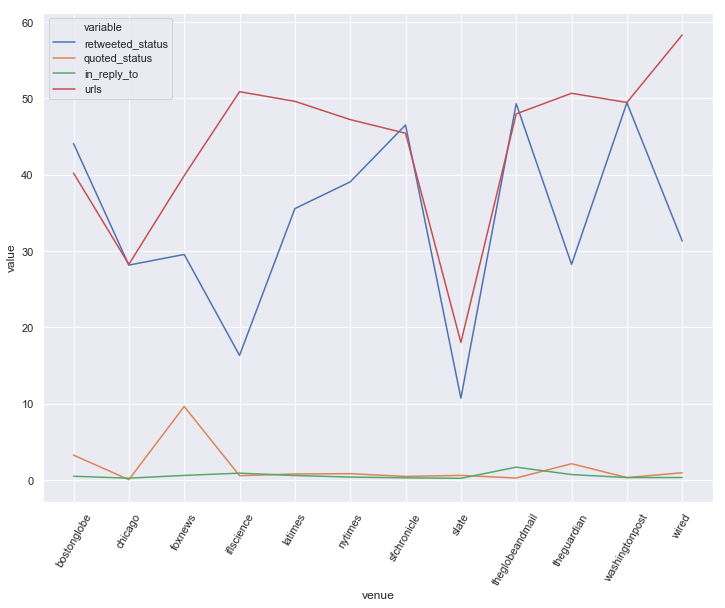

In [153]:
pdf = x.div(x.total/100, axis=0)
pdf = pdf.reset_index().melt(id_vars="venue", value_vars=['retweeted_status', 'quoted_status', 'in_reply_to', 'urls'])

ax = sns.lineplot(x="venue", y="value", hue="variable", data=pdf)
plt.xticks(rotation=60);

In [131]:
t = tweets.shape[0]

In [132]:
x = tweets.error.count()
print("{} failed tweets ({:.2f}%)\n".format(x, 100*x/t))
pprint(tweets.error.value_counts())

5781 failed tweets (0.16%)

[{'code': 144, 'message': 'No status found with that ID.'}]                        2882
[{'code': 63, 'message': 'User has been suspended.'}]                              2633
[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]     213
[{'code': 34, 'message': 'Sorry, that page does not exist.'}]                        53
Name: error, dtype: int64


In [143]:
x = tweets.retweeted_status.count()
y = tweets.retweeted_status.nunique()
print("{} ({:.2f}%) unique tweets were retweeted by {} ({:.2f}%) tweets\n".format(y, 100*y/t, x, 100*x/t))

rts = set(tweets.retweeted_status.dropna().unique())
ts = set(tweets.tweet_id.tolist())
found_rts = len(rts.intersection(ts))

print("Of those {} retweeted statuses we find {} ({:.2f}%) in our dataset\n".format(y, found_rts, 100*found_rts/y))

203118 (5.65%) unique tweets were retweeted by 2315412 (64.41%) tweets

Of those 203118 retweeted statuses we find 194542 (95.78%) in our dataset



In [144]:
x = tweets.quoted_status.count()
y = tweets.quoted_status.nunique()
print("{} ({:.2f}%) unique tweets were quoted by {} ({:.2f}%) tweets\n".format(y, 100*y/t, x, 100*x/t))

rts = set(tweets.quoted_status.dropna().unique())
ts = set(tweets.tweet_id.tolist())
found_rts = len(rts.intersection(ts))

print("Of those {} quoted statuses we find {} ({:.2f}%) in our dataset\n".format(y, found_rts, 100*found_rts/y))

9315 (0.26%) unique tweets were quoted by 74460 (2.07%) tweets

Of those 9315 quoted statuses we find 2561 (27.49%) in our dataset

